<a href="https://colab.research.google.com/github/MDMaaz304/BDA_Assignment2/blob/main/BDA_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Model using Logistic Regression in PySpark

+-----+----------+------------------------------------------+
|label|prediction|probability                               |
+-----+----------+------------------------------------------+
|0.0  |0.0       |[0.999384429811193,6.155701888069798E-4]  |
|0.0  |0.0       |[0.9924801443367608,0.0075198556632392055]|
|0.0  |0.0       |[0.9966668625481935,0.0033331374518065227]|
|0.0  |0.0       |[0.9967875493157639,0.0032124506842361455]|
|0.0  |0.0       |[0.999065604515012,9.34395484987971E-4]   |
|0.0  |0.0       |[0.998256535811736,0.0017434641882639879] |
|0.0  |0.0       |[0.9994410089962351,5.58991003764886E-4]  |
|0.0  |0.0       |[0.9986242089088248,0.0013757910911752491]|
|0.0  |0.0       |[0.9987526431852547,0.001247356814745304] |
|0.0  |0.0       |[0.9990382316232586,9.617683767414453E-4] |
|0.0  |0.0       |[0.9987790019195101,0.0012209980804899212]|
|0.0  |0.0       |[0.9987145282364133,0.0012854717635867319]|
|0.0  |0.0       |[0.9986529029702086,0.0013470970297914109]|
|0.0  |0

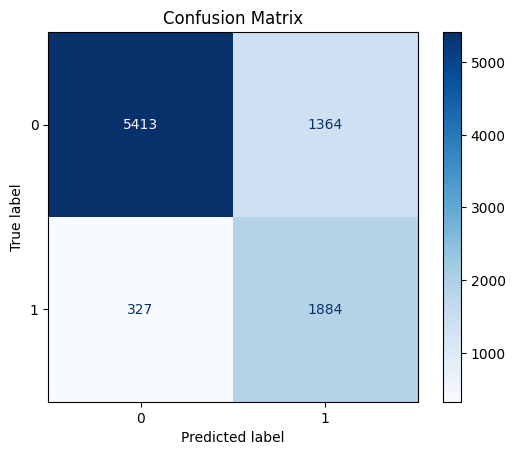

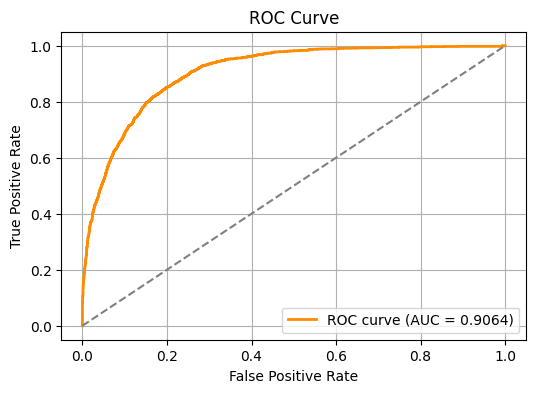

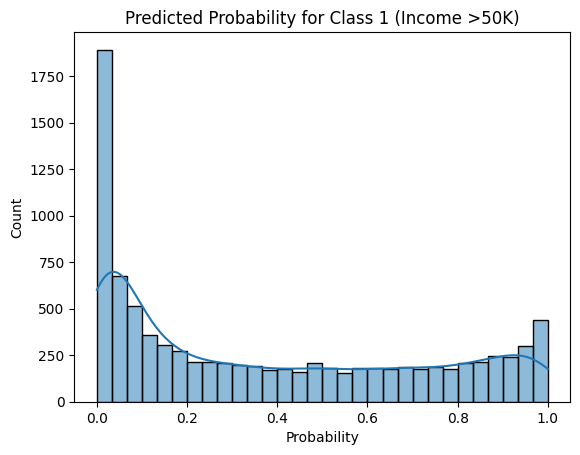

In [7]:
# STEP 1: Install Required Libraries
!pip install -q pyspark

# STEP 2: Imports
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# STEP 3: Initialize Spark Session
spark = SparkSession.builder.appName("Adult Income Classification").getOrCreate()

# STEP 4: Download and Load Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
local_path = "/content/adult.data"
urllib.request.urlretrieve(url, local_path)

columns = ["age", "workclass", "fnlwgt", "education", "education_num",
           "marital_status", "occupation", "relationship", "race", "sex",
           "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"]

data = spark.read.csv(local_path, header=False, inferSchema=True)
data = data.toDF(*columns)
data = data.replace(' ?', None).dropna()

# STEP 5: Label Encoding (before balancing)
label_indexer = StringIndexer(inputCol="income", outputCol="label")
data = label_indexer.fit(data).transform(data)

# STEP 6: Train-Test Split
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

# STEP 7: Balance Class Weights
major = train_data.filter(col("label") == 0.0).count()
minor = train_data.filter(col("label") == 1.0).count()
balancing_ratio = minor / major

train_data = train_data.withColumn("classWeightCol",
    when(col("label") == 0.0, balancing_ratio).otherwise(1.0)
)

# STEP 8: Preprocessing + Model
categorical_cols = ["workclass", "education", "marital_status", "occupation",
                    "relationship", "race", "sex", "native_country"]
numerical_cols = ["age", "fnlwgt", "education_num", "capital_gain",
                  "capital_loss", "hours_per_week"]

indexers = [StringIndexer(inputCol=c, outputCol=c+"_index") for c in categorical_cols]
encoders = [OneHotEncoder(inputCol=c+"_index", outputCol=c+"_ohe") for c in categorical_cols]
assembler_inputs = [c+"_ohe" for c in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

lr = LogisticRegression(featuresCol="features", labelCol="label", weightCol="classWeightCol")
pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])

# STEP 9: Train Model
model = pipeline.fit(train_data)

# STEP 10: Predict
predictions = model.transform(test_data)
predictions.select("label", "prediction", "probability").show(15, truncate=False)

# STEP 11: Evaluate
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
auc_score = evaluator.evaluate(predictions)
print(f"\nArea Under ROC Curve (AUC): {auc_score:.4f}")

# STEP 12: Visualizations
preds_pd = predictions.select("label", "prediction", "probability").toPandas()
preds_pd["prob_1"] = preds_pd["probability"].apply(lambda x: float(x[1]))

# Confusion Matrix
cm = confusion_matrix(preds_pd["label"], preds_pd["prediction"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(preds_pd["label"], preds_pd["prob_1"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Probability Distribution
sns.histplot(preds_pd["prob_1"], bins=30, kde=True)
plt.title("Predicted Probability for Class 1 (Income >50K)")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()


AUC (0.9064) indicates that the model has a high ability to distinguish between the two classes (income ≤50K and income >50K).

The predicted probabilities are providing a strong distinction between the classes (as you can see, most predictions are very close to either 0.0 or 1.0).

This project was about classifying income levels (higher or lower than 50K) based on the Adult Income Dataset.

Major steps were:

Data Preprocessing: Cleaning the dataset, encoding categorical features, and missing value handling.

Handling Class Imbalance: Used class weights to handle class imbalance in the target variable.

Model Training: A Logistic Regression model was utilized, with an AUC of 0.9064, reflecting excellent predictive performance.

Evaluation: The performance of the model was evaluated using metrics such as AUC, ROC curve, and confusion matrix.

Results:
The model exhibited good capability to separate income classes.

Class balancing contributed to enhancing performance, particularly for the minority class.


# kmean Clustering on digit dataset using pyspark

In [13]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from sklearn.datasets import load_digits
import pandas as pd

# Step 1: Load the Digits dataset from sklearn
digits = load_digits()
df = pd.DataFrame(digits.data, columns=[f"pixel_{i}" for i in range(digits.data.shape[1])])
df['label'] = digits.target  # Add the target labels for reference

# Step 2: Initialize Spark session
spark = SparkSession.builder \
    .appName("Digits KMeans Clustering") \
    .getOrCreate()

# Convert the Pandas DataFrame to a Spark DataFrame
spark_df = spark.createDataFrame(df)

# Show the first few rows of the dataset
spark_df.show(5)

# Step 3: Feature Engineering using VectorAssembler
feature_columns = [col for col in df.columns if col != 'label']  # Exclude the target column 'label'
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Show the transformed dataframe with features vector
assembled_df = assembler.transform(spark_df)
assembled_df.select("label", "features").show(5)

# Step 4: Apply KMeans Clustering
kmeans = KMeans(k=10, seed=1, featuresCol="features", predictionCol="prediction")

# Create a pipeline
pipeline = Pipeline(stages=[assembler, kmeans])

# Fit the model
model = pipeline.fit(spark_df)

# Step 5: Make Predictions
predictions = model.transform(spark_df)

# Show the first 5 rows with cluster predictions
predictions.select("label", "prediction").show(5)

# Step 6: Evaluate Clustering Model
wssse = model.stages[-1].summary.trainingCost  # Accessing the WSSSE from the model summary
print(f"Within Set Sum of Squared Errors (WSSSE): {wssse}")


+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----+
|pixel_0|pixel_1|pixel_2|pixel_3|pixel_4|pixel_5|pixel_6|pixel_7|pixel_8|pixel_9|pixel_10|pixel_11|pixel_12|pixel_13|pixel_14|pixel_15|pixel_16|pixel_17|pixel_18|pixel_19|pixel_20|pixel_21|pixel_22|pixel_23|pixel_24|pixel_25|pixel_26|pixel_27|pixel_28|pixel_29|pixel_30|pixel_31|pixel_32|pixel_33|pixel_34|pixel_35|pixel_36|pixel_37|pixel_38|pixel_39|pixel_40|pixel_41|pixel_42|pixel_43|pixel_44|pixel_45|pixel_46|pixel_47|pix

In this project, i used KMeans clustering on the Digits dataset, which is 8x8 pixel images of hand-written digits (0-9). The data was processed in PySpark's machine learning pipeline, with feature transformation using VectorAssembler and model fitting with KMeans clustering.

The major steps were:

Loading and converting the data into a form that is compatible with PySpark.

Using KMeans clustering to divide the data into 10 clusters, each representing the 10 possible digits.

Assessing the performance of the model based on the Within Set Sum of Squared Errors (WSSSE), which was 1167985.304270969.

The results indicate that KMeans was successful in clustering the images, although the quality of clustering can be further assessed by comparing the predictions with the true digit labels.

This method can be applied to other clustering problems as well, and further tuning the model (such as varying the number of clusters) might better suit real-world problems such as image classification or anomaly detection.

# Movie Recommendation System

In [3]:
# Step 1: Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd

# Step 2: Initialize Spark Session
spark = SparkSession.builder \
    .appName("MovieLens Recommendation Engine") \
    .getOrCreate()

# Step 3: Load the MovieLens 100k dataset
# The dataset contains 100,000 ratings from 943 users on 1682 movies
url = "https://files.grouplens.org/datasets/movielens/ml-100k/u.data"
columns = ['userId', 'movieId', 'rating', 'timestamp']

# Read using pandas
df_pd = pd.read_csv(url, sep='\t', names=columns)

# Drop unnecessary columns and convert to Spark DataFrame
df = spark.createDataFrame(df_pd.drop('timestamp', axis=1))

# Display sample data
print("Sample Ratings:")
df.show(5)

# Step 4: Split data into training and testing sets (80-20 split)
training_data, testing_data = df.randomSplit([0.8, 0.2])

# Step 5: Build the ALS (Alternating Least Squares) recommendation model
als_model = ALS(
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop"  # Drop NaNs during prediction
)

# Train the ALS model on the training data
model = als_model.fit(training_data)

# Step 6: Predict ratings on the test data
predictions = model.transform(testing_data)

# Step 7: Evaluate the model using Root Mean Squared Error (RMSE)
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse:.4f}")

# Step 8: Generate Top-5 movie recommendations for all users
recommendations = model.recommendForAllUsers(5)

# Display sample recommendations
print("Top-5 Movie Recommendations for Users:")
recommendations.show(5, truncate=False)

Sample Ratings:
+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|   196|    242|     3|
|   186|    302|     3|
|    22|    377|     1|
|   244|     51|     2|
|   166|    346|     1|
+------+-------+------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data: 0.9297
Top-5 Movie Recommendations for Users:
+------+----------------------------------------------------------------------------------------------+
|userId|recommendations                                                                               |
+------+----------------------------------------------------------------------------------------------+
|1     |[{1463, 5.7238812}, {1643, 5.4142146}, {1367, 5.1444244}, {1449, 5.0521073}, {1639, 5.025752}]|
|2     |[{1643, 5.4500227}, {1463, 5.1278567}, {1449, 4.941241}, {1368, 4.87072}, {1398, 4.860909}]   |
|3     |[{320, 4.527016}, {850, 4.4167786}, {854, 4.3000383}, {913, 4.043921}, {1589, 4.022668}]      |
|4     |[{1589, 6.069956}, {